# Transfer Learning with Tensorflow Part 1 : Feature Extraction 

Transfer learning is leveraging a working model existing learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own 
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own , then we can adapt those patterns to our own data 

## Downloading and becoming one with data 

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.10.0
Hub version: 0.16.1
GPU is available


In [2]:
# run this cell only once
# get data (10% of 10 food classes from food 101)

import zipfile
# import wget

# url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
# folder = wget.download(url)

# unzip the downloaded folder

# zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
# zip_ref.extractall()
# zip_ref.close()

In [3]:
# how many images in each folder .?

import os

# Walk through 10 percent data directory and list number of files 

for dirpath ,dirnames,filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' ")


There are 2 directories and 0 images in '10_food_classes_10_percent' 
There are 10 directories and 0 images in '10_food_classes_10_percent\test' 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry' 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings' 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice' 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon' 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger' 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream' 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza' 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen' 
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak' 
There are 0 directories and 250 images in '10_food_classes_10_percent

## Create data loaders (preparing the data)

We will use the ImageDataGenerator class to load in our images in batches 

In [4]:
import tensorflow as tf  # type: ignore
tf. __version__ 
# tf.device('/device:GPU:0')

'2.10.0'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

IMAGE_SHAPE =(224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen =ImageDataGenerator(rescale = 1/255.)

print('Training images: ')
train_data_10_percent =train_datagen.flow_from_directory(train_dir,
                                                         target_size =IMAGE_SHAPE,
                                                         batch_size =BATCH_SIZE,
                                                         class_mode ='categorical')

print('Testing Images')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size =BATCH_SIZE,
                                             class_mode ='categorical')

Training images: 
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


## Setting up callbacks 

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with TensorflowBoard Callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training with the EarlyStopping callback



In [6]:
# Create Tensorflow callback
import datetime 
import tensorflow as tf  # type: ignore

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir) # type: ignore
    print(f'Saving TensorBoard log files to:{log_dir}')
    return tensorboard_callback


**Note**: you can customize the directory where your TensorBoard logs get saved to whatever you like .
The log_dir parameter we have created above is only one option 

## Creating models with tensorflow hub

In [7]:
# Lets compare the following two models 
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"

efficient_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2"


In [8]:
#  import dependecies 

import tensorflow as tf  # type: ignore
import tensorflow_hub as hub 
from tensorflow.keras import  layers # type: ignore

In [9]:
def create_model(model_url , num_classes =10):
    """
    Takes a tensorflow hub URL and create a Keras Sequential model with it 

    Args :
    model_url(str): a Tensorflow hub feature extraction URL 
    num_classes (int) : Number of output neurons in output layer,
    should be equal to number of target classes,default 10.

    Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons
    """
    #  Download our pretrained model and save it as a keras layer 

    feature_extractor_layer = hub.KerasLayer(model_url, # type: ignore
                                            trainable =False,
                                            name ='feature_extractor_layer',
                                            input_shape =IMAGE_SHAPE+(3,))
    
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes,activation='softmax',name ='output_layer')
    ])
    
    # model = tf.keras.Sequential([
    #     hub.KerasLayer(model_url,
    #                trainable=False,
    #                name ='feature_extractor_layer',
    #                input_shape = IMAGE_SHAPE+(3,)),  # Can be True, see below.
    #     tf.keras.layers.Dense(num_classes, activation='softmax')
    # ])

    return model

In [10]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [11]:
# m = tf.keras.Sequential([
#     hub.KerasLayer("https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1",
#                    trainable=False),  # Can be True, see below.
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])
# m.build([None, 224, 224, 3])  # Batch input shape.


### Creating and testing Resnet TensorFlow Hub feature Extraction model

In [12]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer =tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [13]:
# lets fit our ResNet model to data 
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs =5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks =[create_tensorboard_callback(dir_name ='tensorflow_hub',
                                                                          experiment_name ='resnet50_v2')])

Saving TensorBoard log files to:tensorflow_hub/resnet50_v2/20240602-172810
Epoch 1/5
24/24 [==============================] - 11s 319ms/step - loss: 2.1048 - accuracy: 0.3360 - val_loss: 1.1517 - val_accuracy: 0.6180
Epoch 2/5
24/24 [==============================] - 7s 288ms/step - loss: 0.9152 - accuracy: 0.7053 - val_loss: 0.7916 - val_accuracy: 0.7520
Epoch 3/5
24/24 [==============================] - 7s 288ms/step - loss: 0.6214 - accuracy: 0.8107 - val_loss: 0.6636 - val_accuracy: 0.7972
Epoch 4/5
24/24 [==============================] - 7s 287ms/step - loss: 0.4476 - accuracy: 0.8920 - val_loss: 0.6066 - val_accuracy: 0.8096
Epoch 5/5
24/24 [==============================] - 7s 288ms/step - loss: 0.3574 - accuracy: 0.9240 - val_loss: 0.5622 - val_accuracy: 0.8260


In [14]:
# Lets create a function to plot loss curves 
def plot_loss_curves(history):
    """"
    Returns separate loss curves for training and validation metrics 
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # plot loss 
    plt.plot(epochs,loss,label='training_loss')
    plt.plot(epochs,val_loss,label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()

    # Plot accuracy 
    plt.figure()
    plt.plot(epochs,accuracy,label='training_accuracy')
    plt.plot(epochs,val_accuracy,label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

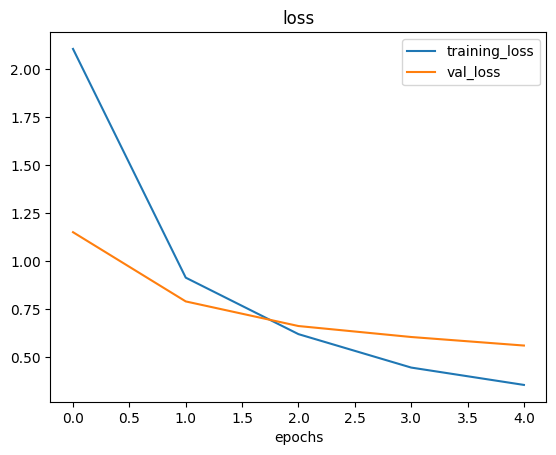

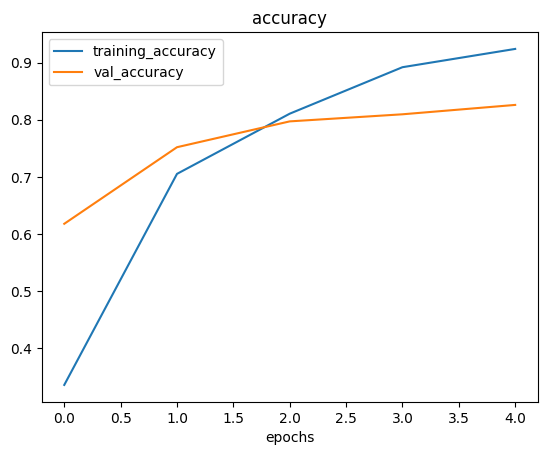

In [15]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNet-v2 model

In [16]:
# Create EfficientNet-v2 model 
efficientnet_model = create_model(model_url=efficient_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile the model 
efficientnet_model.compile(loss ='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics =['accuracy'])

# Fit effificentnet_v2 model to our 10 % of training data
efficientNet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks =[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                      experiment_name = 'efficienNet_v2')])

                                              


Saving TensorBoard log files to:tensorflow_hub/efficienNet_v2/20240602-172851
Epoch 1/5
24/24 [==============================] - 10s 241ms/step - loss: 2.1043 - accuracy: 0.3200 - val_loss: 1.1985 - val_accuracy: 0.5944
Epoch 2/5
24/24 [==============================] - 5s 207ms/step - loss: 1.0057 - accuracy: 0.6867 - val_loss: 0.9049 - val_accuracy: 0.6976
Epoch 3/5
24/24 [==============================] - 5s 207ms/step - loss: 0.7498 - accuracy: 0.7600 - val_loss: 0.8062 - val_accuracy: 0.7384
Epoch 4/5
24/24 [==============================] - 5s 207ms/step - loss: 0.6133 - accuracy: 0.8173 - val_loss: 0.7712 - val_accuracy: 0.7520
Epoch 5/5
24/24 [==============================] - 5s 207ms/step - loss: 0.5230 - accuracy: 0.8600 - val_loss: 0.7240 - val_accuracy: 0.7644


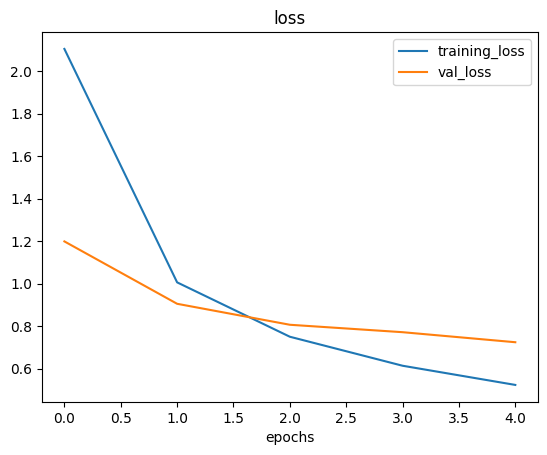

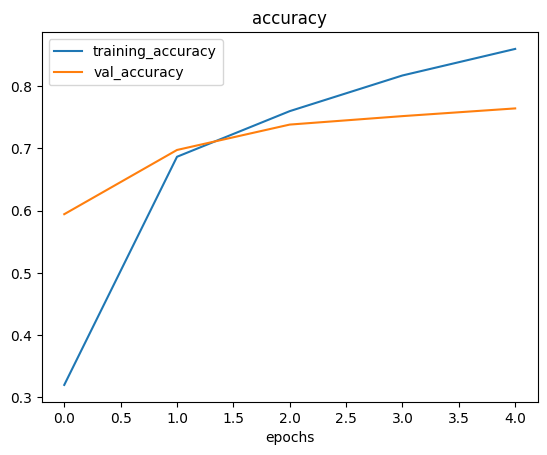

In [17]:
plot_loss_curves(efficientNet_history)

In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1000)             7200312   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 7,210,322
Trainable params: 10,010
Non-trainable params: 7,200,312
_________________________________________________________________


In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23561152  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


## Comparing our models results using Tensorflow 

